In [1]:
import os
from scipy import stats
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import pickle
import glob
import pandas as pd
from warnings import warn
import seaborn as sns
from dPCA import dPCA
import matplotlib.patheffects as pe
# import matplotx
# plt.style.use(matplotx.styles.aura["dark"])


In [2]:
mpl.rcParams.update(
    {
        "axes.titlesize": 18,
        "axes.spines.bottom": True,
        "axes.spines.top": False,
        "axes.spines.left": True,
        "axes.spines.right": False,
        "xtick.bottom": True,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.linewidth": 1.5,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
    }
)


def trial_xticks(ax, bin_sizes=[5, 25, 15, 7, 15]):
    bin_locs = np.cumsum(bin_sizes)
    ax.set_xticks([0] + bin_locs.tolist())
    ax.set_xticklabels([])
    ax.tick_params("x", length=17, width=1, which="major")
    ax.set_xlabel("Time", labelpad=10)

    periods = ["S", "Cue", "Delay", "Arm", "Reward"]
    for i in range(5):
        xloc = ([0] + bin_locs.tolist())[i] + bin_sizes[i] / 2
        ax.text(
            xloc,
            -0.03,
            periods[i],
            fontsize=10,
            horizontalalignment="center",
            verticalalignment="top",
            transform=ax.get_xaxis_transform(),
            rotation=0,
        )


cmap = sns.color_palette("terrain", 10, desat=0.45)
colors = [cmap[-4], cmap[3]]
cmap


[(0.288954248366013, 0.45130718954248356, 0.6313071895424838),
 (0.2248529411764706, 0.5222058823529411, 0.5927941176470588),
 (0.28423529411764714, 0.6145882352941177, 0.43458823529411783),
 (0.5778823529411765, 0.7727058823529411, 0.5927058823529413),
 (0.7889803921568627, 0.8539215686274509, 0.673921568627451),
 (0.8112137254901959, 0.7998490196078429, 0.6498843137254904),
 (0.6536411764705883, 0.6195470588235295, 0.5296529411764705),
 (0.48921764705882353, 0.4314058823529412, 0.4041941176470589),
 (0.6054823529411765, 0.5600235294117648, 0.5502823529411766),
 (0.8027411764705883, 0.7800117647058824, 0.7751411764705882)]

# Read in data from pickle files

In [3]:
# pickle files:
picklef = glob.glob("/jukebox/witten/yousuf/rotation/pickles2/loop_files/*.pickle")
print(pd.DataFrame([i.split("/")[-1] for i in picklef]))


                                      0
0    allSpikeData_ACC_direct_NoD.pickle
1  allSpikeData_DMS_indirect_NoD.pickle
2    allSpikeData_ACC_direct_AoE.pickle
3  allSpikeData_ACC_indirect_NoD.pickle
4  allSpikeData_DMS_indirect_AoE.pickle
5  allSpikeData_ACC_indirect_AoE.pickle
6    allSpikeData_DMS_direct_AoE.pickle
7    allSpikeData_DMS_direct_NoD.pickle


In [4]:
# pick a file:
fnum = 4
with open(picklef[fnum], "rb") as handle:
    data = pickle.load(handle)
keys = data.keys()
# selecting the key that includes single and multi-unit recordings:
key = [key for i, key in enumerate(keys) if key.split("_")[1] == "all"]
data = data[key[0]]
plt.close("all")


In [5]:
# pick a mouse and date:

mouseID = np.array(data["mouseID"])
print(f"mice: {np.unique(mouseID)}")
mouse_pick = 3  # pick mouse index here
mouse = np.unique(mouseID)[mouse_pick]

all_dates = np.asarray(data["date"])
# dates associated with that mouse:
dates = np.unique(all_dates[mouseID == mouse])
print(f"dates: {dates}")
date = dates[0]  # pick date index here

# index of mouse/dates of interest in data:
idx = np.nonzero((all_dates == date) * (mouseID == mouse))[0]
print(f"number of neurons for mouse {mouse} on {date}: {idx.size}")

# strings used for plot titles later:
ephys_loc = picklef[fnum].split("_")[2][-3:]
opto_loc = picklef[fnum].split("_")[3][:-3]
task = picklef[fnum].split("_")[4][:3]


mice: [248. 249. 250. 492.]
dates: [20220603. 20220604. 20220605. 20220606. 20220609. 20220610. 20220611.
 20220617. 20220618. 20220619.]
number of neurons for mouse 492.0 on 20220603.0: 173


### Extract data for selected mouse/date:

In [6]:
bin_sizes = [5, 25, 15, 7, 15]
bin_locs = np.cumsum(bin_sizes)

# lists to store spike rate data for laser off and laser on trials
# and the trials' respective indices
# index 0 is laser off, index 1 is laser on
alldata_lsr = [None, None]
trial_idx_lsr = [None, None]

for laser in [0, 1]:
    # extracting index where the maze type is >7 for laser on vs off trials
    trial_idx = np.nonzero(
        (data["currMaze"][idx[0]] > 7) * (data["laserON"][idx[0]] == laser)
    )[0]
    # add the following to the trial index boolean operation to include only state 3 trials:
    # *(data['stateID'][idx[0]] == 3)

    trial_idx_lsr[laser] = trial_idx

    n_neurons = idx.size

    [n_trials, n_bins] = data["timeSqueezedFR"][idx[0]][trial_idx, :].shape

    alldata = np.zeros((n_trials, n_neurons, n_bins))

    correcttrials = np.where(
        data["choice"][idx[0]][trial_idx] == data["trialType"][idx[0]][trial_idx], 1, 0
    )
    print(
        f"fraction correct for laser {['off', 'on'][laser]}: {correcttrials.sum()}/{correcttrials.size}"
        f" = {correcttrials.sum()/correcttrials.size:.2f}"
    )

    # for each neuron, get time squeezed firing rate for all trials and time points:
    for i, id in enumerate(idx):
        alldata[:, i, :] = data["timeSqueezedFR"][id][trial_idx, :]

    alldata[np.isnan(alldata)] = 0  # replace nan values with 0

    alldata_lsr[laser] = alldata


fraction correct for laser off: 114/165 = 0.69
fraction correct for laser on: 32/53 = 0.60


# dPCA Analysis

[dPCA github](https://github.com/machenslab/dPCA)

### dPCA with laser and decision conditions:

In [7]:
# creating data matrices and fitting dPCA

choice1 = data["choice"][idx[0]][trial_idx_lsr[0]]  # laser off choices
choice2 = data["choice"][idx[0]][trial_idx_lsr[1]]  # laser on choices

# number of states for each experimental condition
n_time = n_bins
n_decision = 2
n_stim = 2

# finding the experimental condition with the least number of trials
# each condition should have the same number of trials for dPCA to work
n_trials = np.min(
    (
        alldata_lsr[0][choice1 == 0, :, :].shape[0],
        alldata_lsr[0][choice1 == 1, :, :].shape[0],
        alldata_lsr[1][choice2 == 0, :, :].shape[0],
        alldata_lsr[1][choice2 == 1, :, :].shape[0],
    )
)
print(f"number of trials included: {n_trials}")

# choosing random trials to include:
# NOTE: result seems to change significantly according to selected trials if n_trials is low
left_off_idx = np.random.randint(0, (choice1 == 0).sum(), n_trials)
right_off_idx = np.random.randint(0, (choice1 == 1).sum(), n_trials)
left_on_idx = np.random.randint(0, (choice2 == 0).sum(), n_trials)
right_on_idx = np.random.randint(0, (choice2 == 1).sum(), n_trials)

# data matrix which includes the average of all trials in each experimental condition:
X = np.empty((n_neurons, n_time, n_decision, n_stim))
X[:, :, 0, 0] = (alldata_lsr[0][choice1 == 0, :, :])[left_off_idx].mean(axis=0)
X[:, :, 1, 0] = (alldata_lsr[0][choice1 == 1, :, :])[right_off_idx].mean(axis=0)
X[:, :, 0, 1] = (alldata_lsr[1][choice2 == 0, :, :])[left_on_idx].mean(axis=0)
X[:, :, 1, 1] = (alldata_lsr[1][choice2 == 1, :, :])[right_on_idx].mean(axis=0)
X = X.transpose(0, 2, 3, 1)  # time should be last axis

# data matrix which includes each individual trial in each experimental condition,
# this is used for cross validation:
X_all = np.empty((n_trials, n_neurons, n_time, n_decision, n_stim))
X_all[:, :, :, 0, 0] = (alldata_lsr[0][choice1 == 0, :, :])[left_off_idx]
X_all[:, :, :, 1, 0] = (alldata_lsr[0][choice1 == 1, :, :])[right_off_idx]
X_all[:, :, :, 0, 1] = (alldata_lsr[1][choice2 == 0, :, :])[left_on_idx]
X_all[:, :, :, 1, 1] = (alldata_lsr[1][choice2 == 1, :, :])[right_on_idx]
X_all = X_all.transpose(0, 1, 3, 4, 2)

# mean centering each neuron:
X = X - X.mean(axis=(1, 2, 3)).reshape(-1, 1, 1, 1)
X_all = X_all - X_all.mean(axis=(0, 2, 3, 4)).reshape(
    1, -1, 1, 1, 1
)  # mean centering each neuron

label = "dst"  # labeling the axes. d=decision/choice, s=laser/stim/inhib, t = time
dpca = dPCA.dPCA(labels=label, n_components=3, regularizer="auto")
dpca.opt_regularizer_flag = True
dpca.n_trials = 5  # number of cross validation folds
dpca.protect = ["t"]  # prevents shuffling through time for cross validation
Xt = dpca.fit_transform(X, X_all)


number of trials included: 11
You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 5
Starting trial  2 / 5
Starting trial  3 / 5
Starting trial  4 / 5
Starting trial  5 / 5
Optimized regularization, optimal lambda =  0.00016398978063355798
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_r

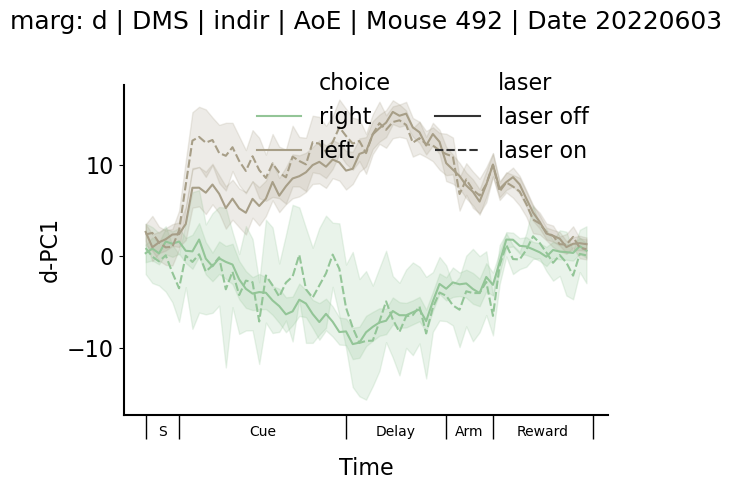

In [8]:
# transforming individual trials into dPCA space and plotting pc vs time

# choose marginalization here (e.g. 'd' for decision space, 'ds' for decision-laser space):
marg = "d"
pc = dpca.D[marg][:, :1]
choices = np.concatenate(
    (data["choice"][idx[0]][trial_idx_lsr[0]], data["choice"][idx[0]][trial_idx_lsr[1]])
)

# transforming laser off trials:
data_T_off = np.squeeze(alldata_lsr[0].transpose(0, 2, 1) @ pc, axis=2)
# transforming laser on trials:
data_T_on = np.squeeze(alldata_lsr[1].transpose(0, 2, 1) @ pc, axis=2)

data_T_all = np.concatenate((data_T_off, data_T_on), axis=0)
# vector indicating which trials are laser on vs off
lsr = np.where(
    np.arange(data_T_all.shape[0]) < data_T_off.shape[0], "laser off", "laser on"
)

# vector indicating which trials are left vs right choice
left_right = np.where(choices == 0, "left", "right")
if left_right[0] == "right":  # to keep left/right color scheme consistent
    colors = colors[::-1]

plot_df = pd.DataFrame(data_T_all, columns=np.arange(data_T_all.shape[1]))
plot_df["laser"] = lsr
plot_df["choice"] = left_right
plot_df = plot_df.melt(  # changing to long-form data frame to get error bars
    id_vars=["laser", "choice"], var_name="time", value_name=marg + "-PC1"
)

# plotting
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.lineplot(
    data=plot_df,
    x="time",
    y=marg + "-PC1",
    hue="choice",
    style="laser",
    palette=colors,
    ax=ax,
)

sns.despine()
plt.legend(loc="upper right", frameon=False, ncol=2, bbox_to_anchor=(1, 1.1))
plt.title(
    f"marg: {marg} | {ephys_loc} | {opto_loc} | {task} | Mouse {mouse:.0f} | Date {date:.0f}",
    pad=40,
)
trial_xticks(ax)

plt.tight_layout()


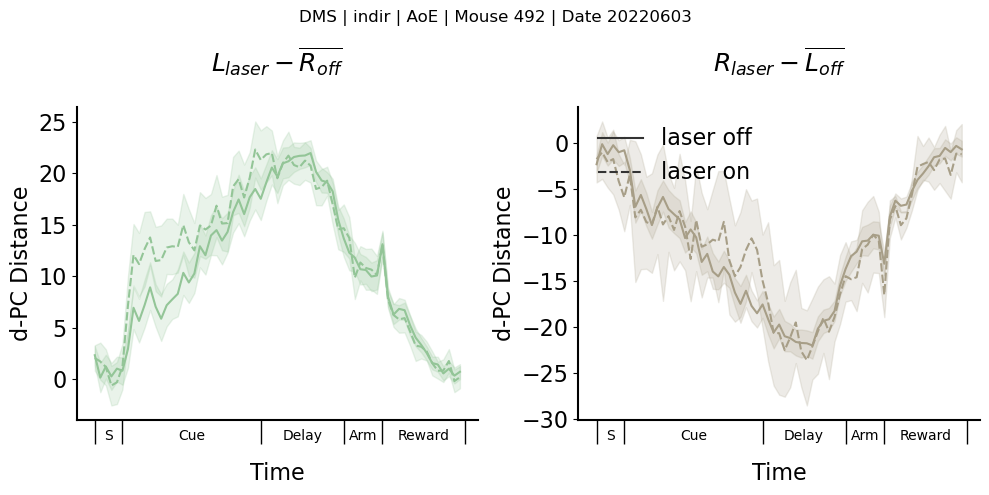

In [9]:
# computing distance between left/right trajectories
# more specfically, we compare (notation is choice_laser) L_off - R_off and L_on - R_off
# and vice versa: R_off - L_off and R_on - L_off

# all trajectories:
left_off = data_T_all[(lsr == "laser off") * (left_right == "left")]
right_off = data_T_all[(lsr == "laser off") * (left_right == "right")]
left_on = data_T_all[(lsr == "laser on") * (left_right == "left")]
right_on = data_T_all[(lsr == "laser on") * (left_right == "right")]

# distances:
roff_minus_loff_mean = right_off - left_off.mean(axis=0)
loff_minus_roff_mean = left_off - right_off.mean(axis=0)
lon_minus_roff_mean = left_on - right_off.mean(axis=0)
ron_minus_loff_mean = right_on - left_off.mean(axis=0)

# number of trials in each choice category
r_trials = roff_minus_loff_mean.shape[0] + ron_minus_loff_mean.shape[0]
l_trials = loff_minus_roff_mean.shape[0] + lon_minus_roff_mean.shape[0]
lr_on_off_trials = (
    roff_minus_loff_mean.shape[0],
    ron_minus_loff_mean.shape[0],
    loff_minus_roff_mean.shape[0],
    lon_minus_roff_mean.shape[0],
)

dist_all = np.concatenate(
    (
        roff_minus_loff_mean,
        ron_minus_loff_mean,
        loff_minus_roff_mean,
        lon_minus_roff_mean,
    ),
    axis=0,
)

# labels for data frame:
left_right_dist = np.repeat(["right", "left"], [r_trials, l_trials])
on_off = np.repeat(["laser off", "laser on", "laser off", "laser on"], lr_on_off_trials)

plot_df = pd.DataFrame(dist_all, columns=np.arange(dist_all.shape[1]))
plot_df["choice"] = left_right_dist
plot_df["laser"] = on_off
plot_df = plot_df.melt(
    id_vars=["choice", "laser"], var_name="time", value_name=marg + "-PC Distance"
)

# plotting:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
titles = [r"$L_{laser} - \overline{R_{off}}$", r"$R_{laser} - \overline{L_{off}}$"]
for i, c in enumerate(["left", "right"]):
    sns.lineplot(
        data=plot_df[plot_df.choice == c],
        x="time",
        y=marg + "-PC Distance",
        hue="choice",
        style="laser",
        palette=colors[i : i + 1],
        ax=axs[i],
    )
    trial_xticks(axs[i])
    sns.despine()
    axs[i].get_legend().remove()
    axs[i].set_title(titles[i], pad=25)

handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(
    handles[3:],
    labels[3:],
    loc="upper left",
    frameon=False,
    ncol=1,
    bbox_to_anchor=(0, 1),
)
plt.suptitle(f"{ephys_loc} | {opto_loc} | {task} | Mouse {mouse:.0f} | Date {date:.0f}")
plt.tight_layout()


### dPCA with decision conditions
Fit only to laser off trials

In [10]:
# creating data matrices and fitting dPCA

choice = data["choice"][idx[0]][trial_idx_lsr[0]]

# number of states for each experimental condition
n_time = n_bins
n_decision = 2
n_stim = 2

# finding the experimental condition with the least number of trials
# each condition should have the same number of trials for dPCA to work
n_trials = np.min(((choice == 0).sum(), (choice == 1).sum()))
print(f"number of trials included: {n_trials}")

# choosing random trials to include:
# NOTE: result seems to change significantly according to selected trials if n_trials is low
left_idx = np.random.randint(0, (choice == 0).sum(), n_trials)
right_idx = np.random.randint(0, (choice == 1).sum(), n_trials)

# data matrix which includes the average of all trials in each experimental condition:
X = np.empty((n_neurons, n_time, n_decision))
X[:, :, 0] = (alldata_lsr[0][choice == 0, :, :])[left_idx].mean(axis=0)
X[:, :, 1] = (alldata_lsr[0][choice == 1, :, :])[right_idx].mean(axis=0)
X = X.transpose(0, 2, 1)  # time should be last axis

# data matrix which includes each individual trial in each experimental condition,
# this is used for cross validation:
X_all = np.empty((n_trials, n_neurons, n_time, n_decision))
X_all[:, :, :, 0] = (alldata_lsr[0][choice == 0, :, :])[left_idx]
X_all[:, :, :, 1] = (alldata_lsr[0][choice == 1, :, :])[right_idx]
X_all = X_all.transpose(0, 1, 3, 2)

# mean centering each neuron:
X = X - X.mean(axis=(1, 2)).reshape(-1, 1, 1)
X_all = X_all - X_all.mean(axis=(0, 2, 3)).reshape(
    1, -1, 1, 1
)  # mean centering each neuron
label = "dt"  # labeling the axes. d=decision/choice, s=laser/stim/inhib, t = time
dpca = dPCA.dPCA(labels=label, n_components=3, regularizer="auto")
dpca.n_trials = 5  # number of cross validation folds
dpca.protect = ["t"]  # prevents shuffling through time
Xt = dpca.fit_transform(X, X_all)


number of trials included: 79
You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 5
Starting trial  2 / 5
Starting trial  3 / 5
Starting trial  4 / 5
Starting trial  5 / 5
Optimized regularization, optimal lambda =  0.0003214199700417736
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_re

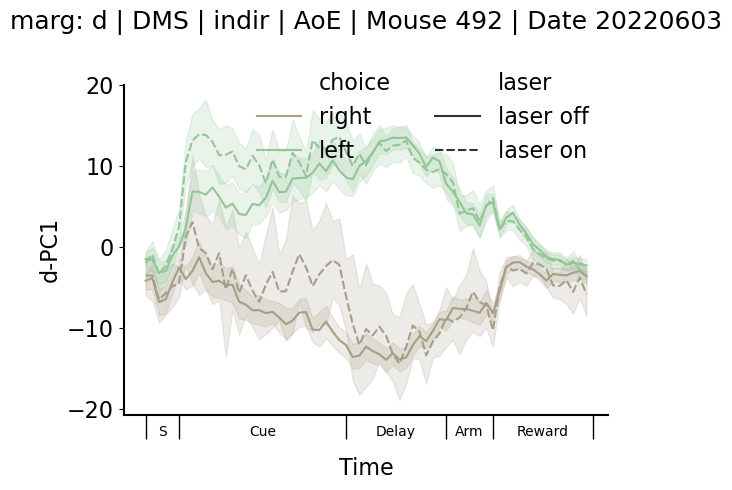

In [11]:
# transforming individual trials into dPCA space and plotting pc vs time

# choose marginalization here (e.g. 'd' for decision space, 'ds' for decision-laser space):
marg = "d"
pc = dpca.D[marg][:, :1]
choices = np.concatenate(
    (data["choice"][idx[0]][trial_idx_lsr[0]], data["choice"][idx[0]][trial_idx_lsr[1]])
)

# transforming laser off trials:
data_T_off = np.squeeze(alldata_lsr[0].transpose(0, 2, 1) @ pc, axis=2)
# transforming laser on trials:
data_T_on = np.squeeze(alldata_lsr[1].transpose(0, 2, 1) @ pc, axis=2)

data_T_all = np.concatenate((data_T_off, data_T_on), axis=0)
# vector indicating which trials are laser on vs off
lsr = np.where(
    np.arange(data_T_all.shape[0]) < data_T_off.shape[0], "laser off", "laser on"
)

# vector indicating which trials are left vs right choice
left_right = np.where(choices == 0, "left", "right")
if left_right[0] == "right":  # to keep left/right color scheme consistent
    colors = colors[::-1]

plot_df = pd.DataFrame(data_T_all, columns=np.arange(data_T_all.shape[1]))
plot_df["laser"] = lsr
plot_df["choice"] = left_right
plot_df = plot_df.melt(  # changing to long-form data frame to get error bars
    id_vars=["laser", "choice"], var_name="time", value_name=marg + "-PC1"
)

# plotting
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.lineplot(
    data=plot_df,
    x="time",
    y=marg + "-PC1",
    hue="choice",
    style="laser",
    palette=colors,
    ax=ax,
)

sns.despine()
plt.legend(loc="upper right", frameon=False, ncol=2, bbox_to_anchor=(1, 1.1))
plt.title(
    f"marg: {marg} | {ephys_loc} | {opto_loc} | {task} | Mouse {mouse:.0f} | Date {date:.0f}",
    pad=40,
)
trial_xticks(ax)

plt.tight_layout()


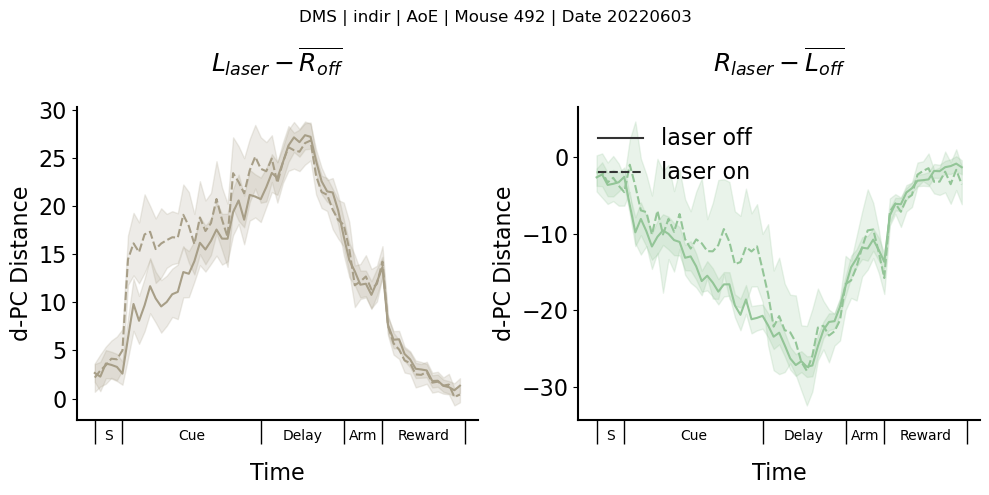

In [12]:
# computing distance between left/right trajectories
# more specfically, we compare (notation is choice_laser) L_off - R_off and L_on - R_off
# and vice versa: R_off - L_off and R_on - L_off

# all trajectories:
left_off = data_T_all[(lsr == "laser off") * (left_right == "left")]
right_off = data_T_all[(lsr == "laser off") * (left_right == "right")]
left_on = data_T_all[(lsr == "laser on") * (left_right == "left")]
right_on = data_T_all[(lsr == "laser on") * (left_right == "right")]

# distances:
roff_minus_loff_mean = right_off - left_off.mean(axis=0)
loff_minus_roff_mean = left_off - right_off.mean(axis=0)
lon_minus_roff_mean = left_on - right_off.mean(axis=0)
ron_minus_loff_mean = right_on - left_off.mean(axis=0)

# number of trials in each choice category
r_trials = roff_minus_loff_mean.shape[0] + ron_minus_loff_mean.shape[0]
l_trials = loff_minus_roff_mean.shape[0] + lon_minus_roff_mean.shape[0]
lr_on_off_trials = (
    roff_minus_loff_mean.shape[0],
    ron_minus_loff_mean.shape[0],
    loff_minus_roff_mean.shape[0],
    lon_minus_roff_mean.shape[0],
)

dist_all = np.concatenate(
    (
        roff_minus_loff_mean,
        ron_minus_loff_mean,
        loff_minus_roff_mean,
        lon_minus_roff_mean,
    ),
    axis=0,
)

# labels for data frame:
left_right_dist = np.repeat(["right", "left"], [r_trials, l_trials])
on_off = np.repeat(["laser off", "laser on", "laser off", "laser on"], lr_on_off_trials)

plot_df = pd.DataFrame(dist_all, columns=np.arange(dist_all.shape[1]))
plot_df["choice"] = left_right_dist
plot_df["laser"] = on_off
plot_df = plot_df.melt(
    id_vars=["choice", "laser"], var_name="time", value_name=marg + "-PC Distance"
)

# plotting:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
titles = [r"$L_{laser} - \overline{R_{off}}$", r"$R_{laser} - \overline{L_{off}}$"]
for i, c in enumerate(["left", "right"]):
    sns.lineplot(
        data=plot_df[plot_df.choice == c],
        x="time",
        y=marg + "-PC Distance",
        hue="choice",
        style="laser",
        palette=colors[i : i + 1],
        ax=axs[i],
    )
    trial_xticks(axs[i])
    sns.despine()
    axs[i].get_legend().remove()
    axs[i].set_title(titles[i], pad=25)

handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(
    handles[3:],
    labels[3:],
    loc="upper left",
    frameon=False,
    ncol=1,
    bbox_to_anchor=(0, 1),
)
plt.suptitle(f"{ephys_loc} | {opto_loc} | {task} | Mouse {mouse:.0f} | Date {date:.0f}")
plt.tight_layout()


### dPCA with evidence conditions
Only laser off trials were used for fitting

In [13]:
# creating data matrices and fitting dPCA

# getting evidence data which is in the form of #R_cues - #L_cues
evidence = data["nCues_RminusL"][idx[0]][trial_idx_lsr[0]]
ev_bins = 2
_, bins = np.histogram(evidence, ev_bins)
bins[-1] += 0.1

# assigning 0 for left evidence and 1 for right evidence:
evidence_level = np.digitize(evidence, bins) - 1
evidence_categories = np.sort(np.unique(evidence_level))

n_time = n_bins
n_decision = 2
n_stim = 2
n_evidence = bins.size - 1
n_trials_all = []

for i_ev, ev in enumerate(evidence_categories):
    n = (evidence_level == ev).sum()
    n_trials_all.append(n)

n_trials = np.min(n_trials_all)
print(f"number of trials included: {n_trials}")

# choosing random trials to include:
# NOTE: result seems to change significantly according to selected trials if n_trials is low
left_idx = np.random.randint(0, (evidence_level == 0).sum(), n_trials)
right_idx = np.random.randint(0, (evidence_level == 1).sum(), n_trials)
lr_idx = [left_idx, right_idx]

# data matrix which includes the average of all trials in each experimental condition:
X = np.empty((n_neurons, n_time, ev_bins))
for i_ev, ev in enumerate(evidence_categories):
    X[:, :, i_ev] = (alldata_lsr[0][evidence_level == ev, :, :])[lr_idx[i_ev]].mean(
        axis=0
    )
X = X.transpose(0, 2, 1)  # time should be last axis

# data matrix which includes each individual trial in each experimental condition,
# this is used for cross validation:
X_all = np.empty((n_trials, n_neurons, n_time, ev_bins))
for i_ev, ev in enumerate(evidence_categories):
    X_all[:, :, :, i_ev] = (alldata_lsr[0][evidence_level == ev, :, :])[lr_idx[i_ev]]
X_all = X_all.transpose(0, 1, 3, 2)
X = X - X.mean(axis=(1, 2)).reshape(-1, 1, 1)  # mean centering each neuron

X_all = X_all - X_all.mean(axis=(0, 2, 3)).reshape(
    1, -1, 1, 1
)  # mean centering each neuron

dpca = dPCA.dPCA(labels="et", n_components=3, regularizer="auto")
dpca.n_trials = 5  # number of cross validation folds
dpca.protect = ["t"]  # prevents shuffling through time
Xt = dpca.fit_transform(X, X_all)


number of trials included: 59
You chose to determine the regularization parameter automatically. This can
                    take substantial time and grows linearly with the number of crossvalidation
                    folds. The latter can be set by changing self.n_trials (default = 3). Similarly,
                    use self.protect to set the list of axes that are not supposed to get to get shuffled
                    (e.g. upon splitting the data into test- and training, time-points should always
                    be drawn from the same trial, i.e. self.protect = ['t']). This can significantly
                    speed up the code.
Start optimizing regularization.
Starting trial  1 / 5
Starting trial  2 / 5
Starting trial  3 / 5
Starting trial  4 / 5
Starting trial  5 / 5
Optimized regularization, optimal lambda =  0.000449987958058483
Regularization will be fixed; to compute the optimal                    parameter again on the next fit, please                    set opt_reg

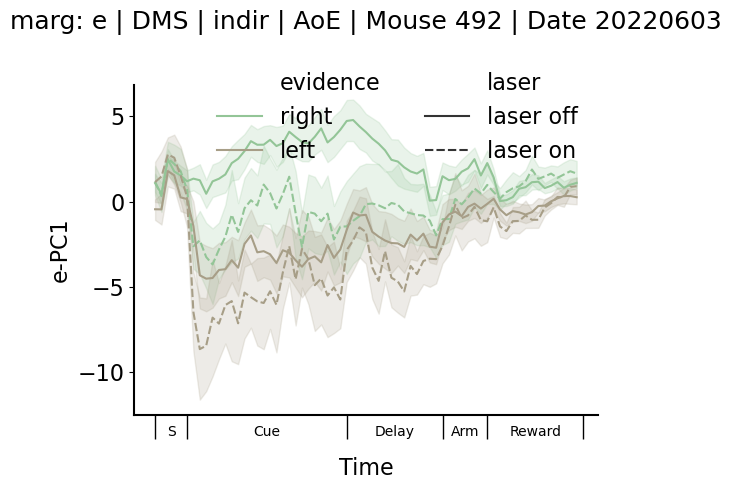

In [14]:
# transforming individual trials into dPCA space and plotting pc vs time

# choose marginalization here (e.g. 'e' for evidence space, 'es' for evidence-laser space):
marg = "e"
pc = dpca.D[marg][:, :1]
evidence1 = np.digitize(data["nCues_RminusL"][idx[0]][trial_idx_lsr[0]], bins) - 1
evidence2 = np.digitize(data["nCues_RminusL"][idx[0]][trial_idx_lsr[1]], bins) - 1
evidence = np.concatenate((evidence1, evidence2))

# transforming laser off trials:
data_T_off = np.squeeze(alldata_lsr[0].transpose(0, 2, 1) @ pc, axis=2)
# transforming laser on trials:
data_T_on = np.squeeze(alldata_lsr[1].transpose(0, 2, 1) @ pc, axis=2)

data_T_all = np.concatenate((data_T_off, data_T_on), axis=0)
# vector indicating which trials are laser on vs off
lsr = np.where(
    np.arange(data_T_all.shape[0]) < data_T_off.shape[0], "laser off", "laser on"
)

# vector indicating which trials are left vs right evidence
left_right = np.where(evidence == 0, "left", "right")
if left_right[0] == "right":  # to keep left/right color scheme consistent
    colors = colors[::-1]

plot_df = pd.DataFrame(data_T_all, columns=np.arange(data_T_all.shape[1]))
plot_df["laser"] = lsr
plot_df["evidence"] = left_right
plot_df = plot_df.melt(  # changing to long-form data frame to get error bars
    id_vars=["laser", "evidence"], var_name="time", value_name=marg + "-PC1"
)

# plotting
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.lineplot(
    data=plot_df,
    x="time",
    y=marg + "-PC1",
    hue="evidence",
    style="laser",
    palette=colors,
    ax=ax,
)

sns.despine()
plt.legend(loc="upper right", frameon=False, ncol=2, bbox_to_anchor=(1, 1.1))
plt.title(
    f"marg: {marg} | {ephys_loc} | {opto_loc} | {task} | Mouse {mouse:.0f} | Date {date:.0f}",
    pad=40,
)
trial_xticks(ax)

plt.tight_layout()


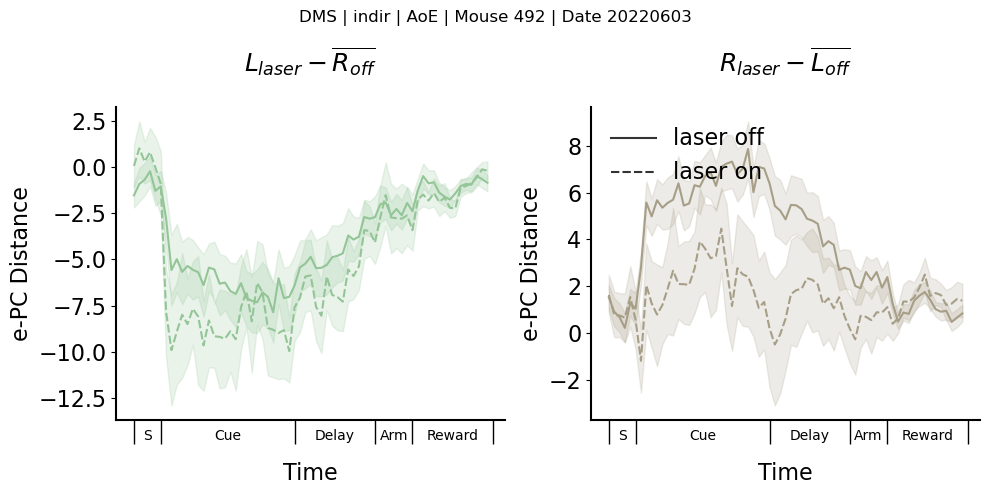

In [15]:
# computing distance between left/right trajectories
# more specfically, we compare (notation is choice_laser) L_off - R_off and L_on - R_off
# and vice versa: R_off - L_off and R_on - L_off

# all trajectories:
left_off = data_T_all[(lsr == "laser off") * (left_right == "left")]
right_off = data_T_all[(lsr == "laser off") * (left_right == "right")]
left_on = data_T_all[(lsr == "laser on") * (left_right == "left")]
right_on = data_T_all[(lsr == "laser on") * (left_right == "right")]

# distances:
roff_minus_loff_mean = right_off - left_off.mean(axis=0)
loff_minus_roff_mean = left_off - right_off.mean(axis=0)
lon_minus_roff_mean = left_on - right_off.mean(axis=0)
ron_minus_loff_mean = right_on - left_off.mean(axis=0)

# number of trials in each choice category
r_trials = roff_minus_loff_mean.shape[0] + ron_minus_loff_mean.shape[0]
l_trials = loff_minus_roff_mean.shape[0] + lon_minus_roff_mean.shape[0]
lr_on_off_trials = (
    roff_minus_loff_mean.shape[0],
    ron_minus_loff_mean.shape[0],
    loff_minus_roff_mean.shape[0],
    lon_minus_roff_mean.shape[0],
)

dist_all = np.concatenate(
    (
        roff_minus_loff_mean,
        ron_minus_loff_mean,
        loff_minus_roff_mean,
        lon_minus_roff_mean,
    ),
    axis=0,
)

# labels for data frame:
left_right_dist = np.repeat(["right", "left"], [r_trials, l_trials])
on_off = np.repeat(["laser off", "laser on", "laser off", "laser on"], lr_on_off_trials)

plot_df = pd.DataFrame(dist_all, columns=np.arange(dist_all.shape[1]))
plot_df["choice"] = left_right_dist
plot_df["laser"] = on_off
plot_df = plot_df.melt(
    id_vars=["choice", "laser"], var_name="time", value_name=marg + "-PC Distance"
)

# plotting:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
titles = [r"$L_{laser} - \overline{R_{off}}$", r"$R_{laser} - \overline{L_{off}}$"]
for i, c in enumerate(["left", "right"]):
    sns.lineplot(
        data=plot_df[plot_df.choice == c],
        x="time",
        y=marg + "-PC Distance",
        hue="choice",
        style="laser",
        palette=colors[i : i + 1],
        ax=axs[i],
    )
    trial_xticks(axs[i])
    sns.despine()
    axs[i].get_legend().remove()
    axs[i].set_title(titles[i], pad=25)

handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(
    handles[3:],
    labels[3:],
    loc="upper left",
    frameon=False,
    ncol=1,
    bbox_to_anchor=(0, 1),
)
plt.suptitle(f"{ephys_loc} | {opto_loc} | {task} | Mouse {mouse:.0f} | Date {date:.0f}")
plt.tight_layout()
